In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from itertools import compress
plt.rcParams['figure.figsize'] = [18, 9]

# CARGA DATASET B&W

In [25]:
image_filenames = os.listdir("data")
for i in range(len(image_filenames)):
    image_filenames[i] = "data/{}".format(image_filenames[i])

print(image_filenames)

image_stack = np.stack([cv2.imread(filename, cv2.IMREAD_GRAYSCALE) for filename in image_filenames], axis=2)
image_stack = np.transpose(image_stack, (2, 0, 1))

image_stack_color = np.stack([cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for filename in image_filenames], axis=2)
image_stack_color = np.transpose(image_stack_color, (2, 3, 0, 1))
print(image_stack_color.shape)

print(image_stack.shape)
plt.imshow(image_stack[7], cmap = "gray")

['data/1660467600.jpg', 'data/1660464000.jpg', 'data/1660460400.jpg', 'data/1660456800.jpg', 'data/1660474800.jpg', 'data/labels_people_detection.csv', 'data/1660485600.jpg', 'data/1660471200.jpg', 'data/1660482000.jpg', 'data/1660478400.jpg', 'data/1660453200.jpg']


ValueError: all input arrays must have the same shape

## Modifiacion de histograma clahe
## Diferencia con playa vacia
## Recorte de montaña y barcos

(-0.5, 1919.5, 1079.5, -0.5)

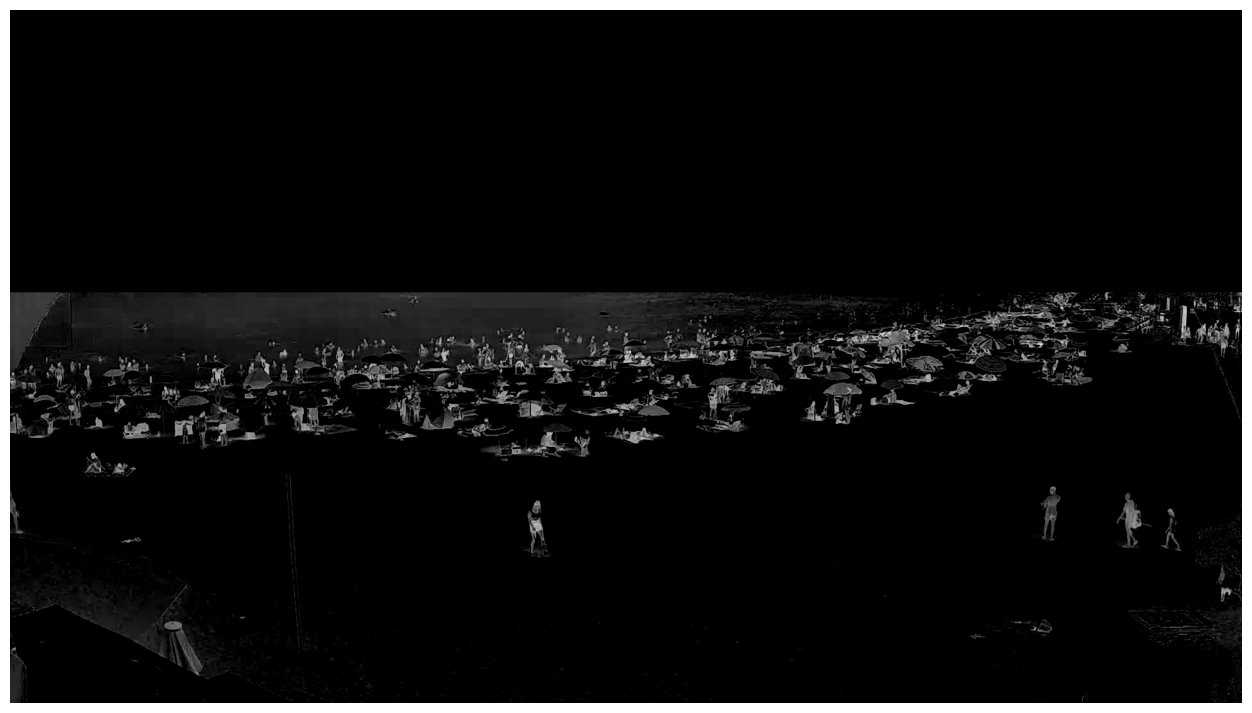

In [3]:
clahe = cv2.createCLAHE(clipLimit=1)

image_mod_3 = image_stack[0].copy()
image_mod_3[0:440,:] = 0

image_mod_9 = image_stack[9].copy()
image_mod_9[0:440,:] = 0

image_mod_4 = image_stack[4].copy()
image_mod_4[0:440,:] = 0

empty_beach_3 = clahe.apply(image_mod_3)

empty_beach_9 = clahe.apply(image_mod_9)

test_image_1 = clahe.apply(image_mod_4)

subs_image = cv2.subtract(empty_beach_9, test_image_1)

plt.imshow(subs_image, cmap = "gray")
plt.axis('off')

# TOPHAT

(-0.5, 1919.5, 1079.5, -0.5)

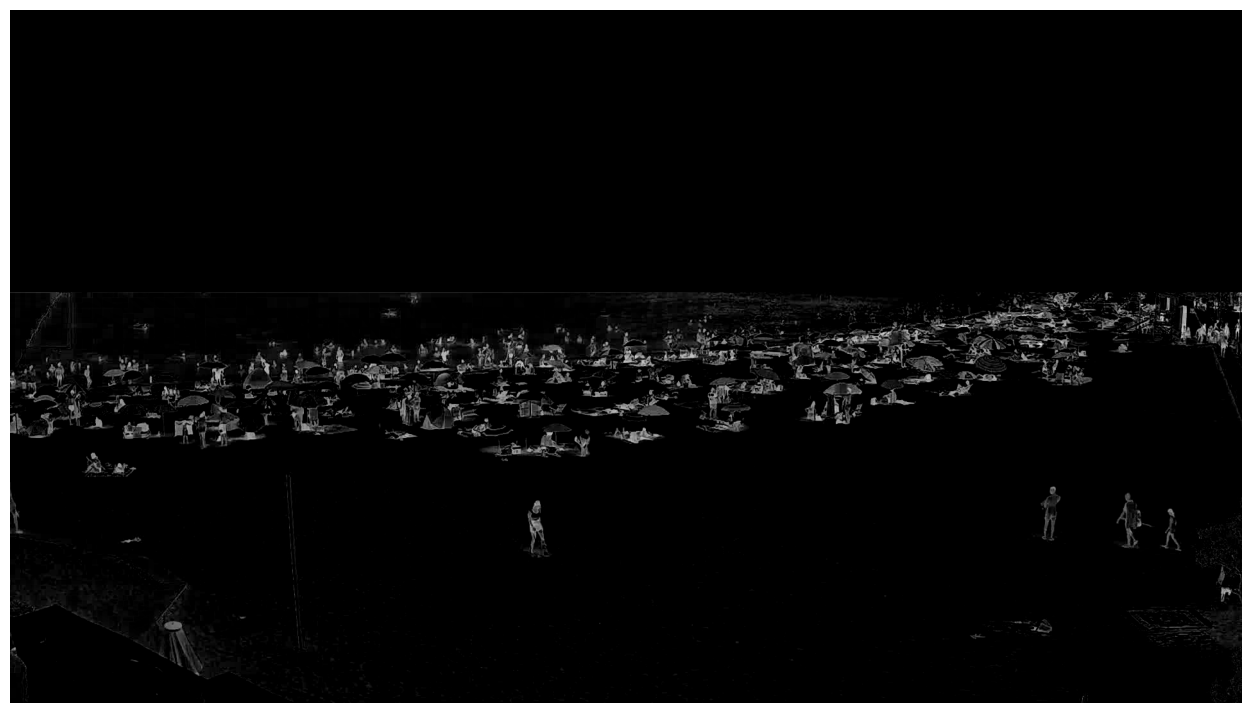

In [4]:
kernelSize = (10,18)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
tophat = cv2.morphologyEx(subs_image, cv2.MORPH_TOPHAT, kernel)

plt.imshow(tophat, cmap="gray")
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

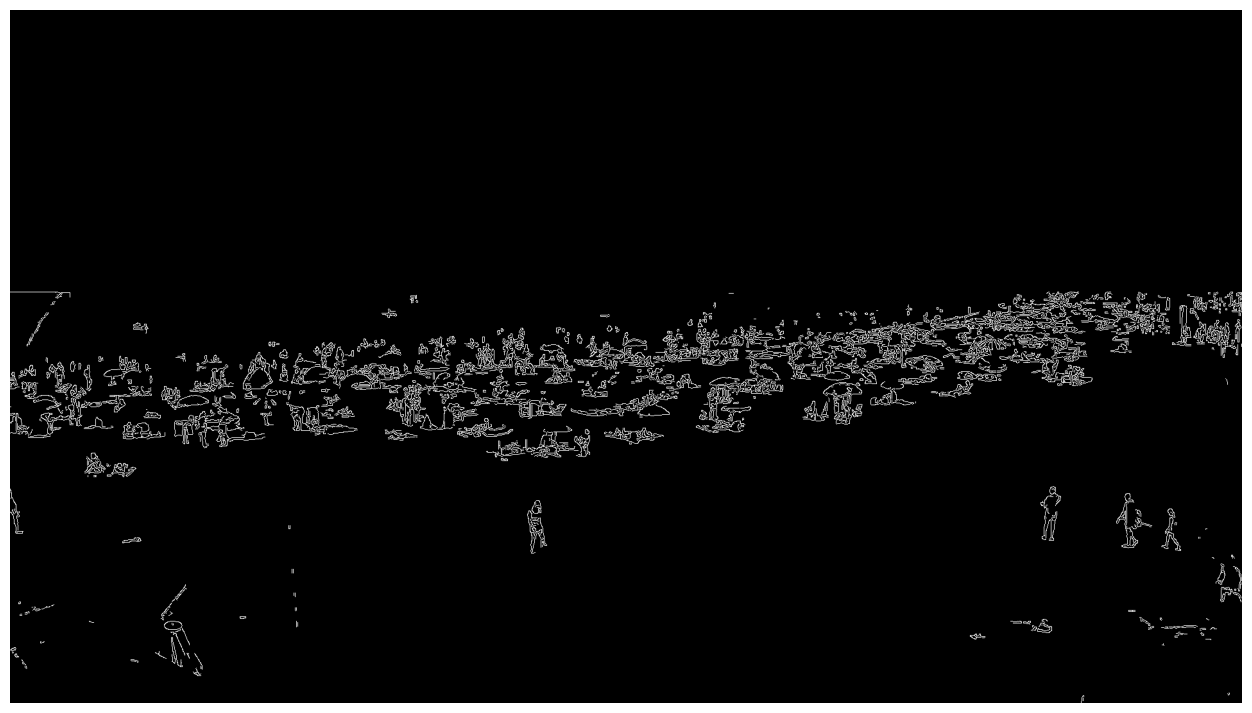

In [5]:
edges = cv2.Canny(image=tophat, threshold1=100, threshold2=200)
plt.imshow(edges, cmap="gray")
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

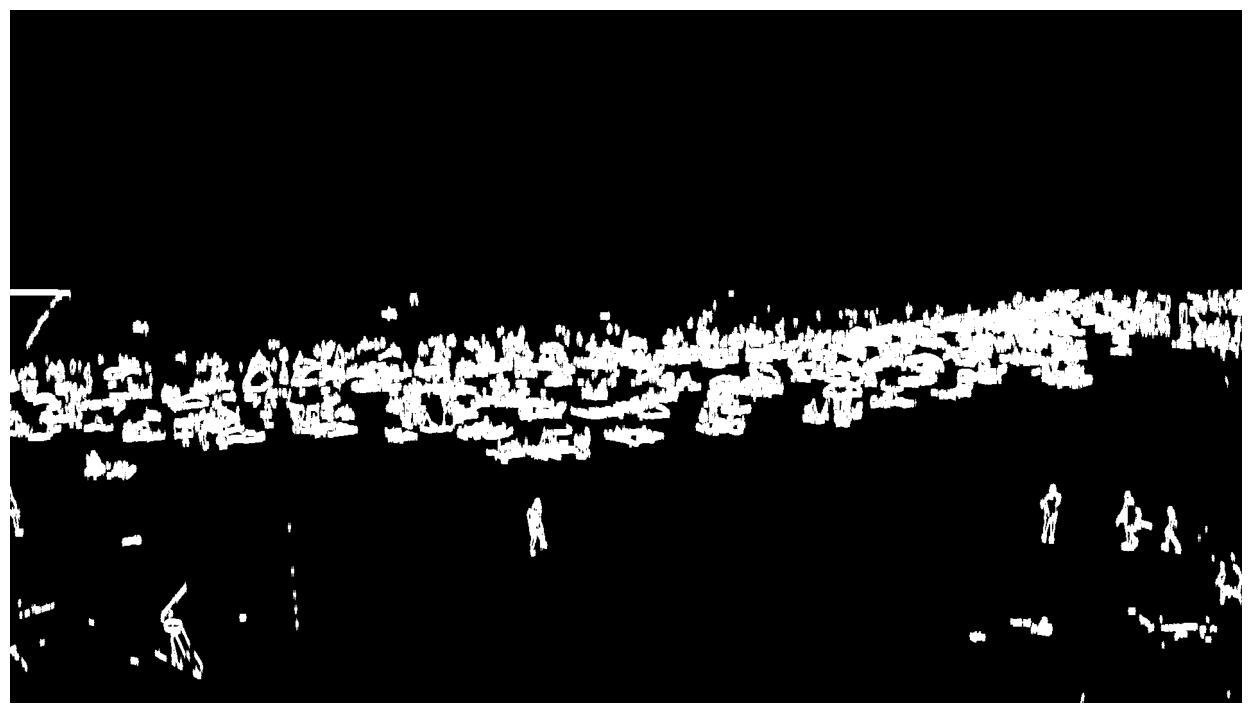

In [25]:
dilated = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))
plt.imshow(dilated, cmap="gray")
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

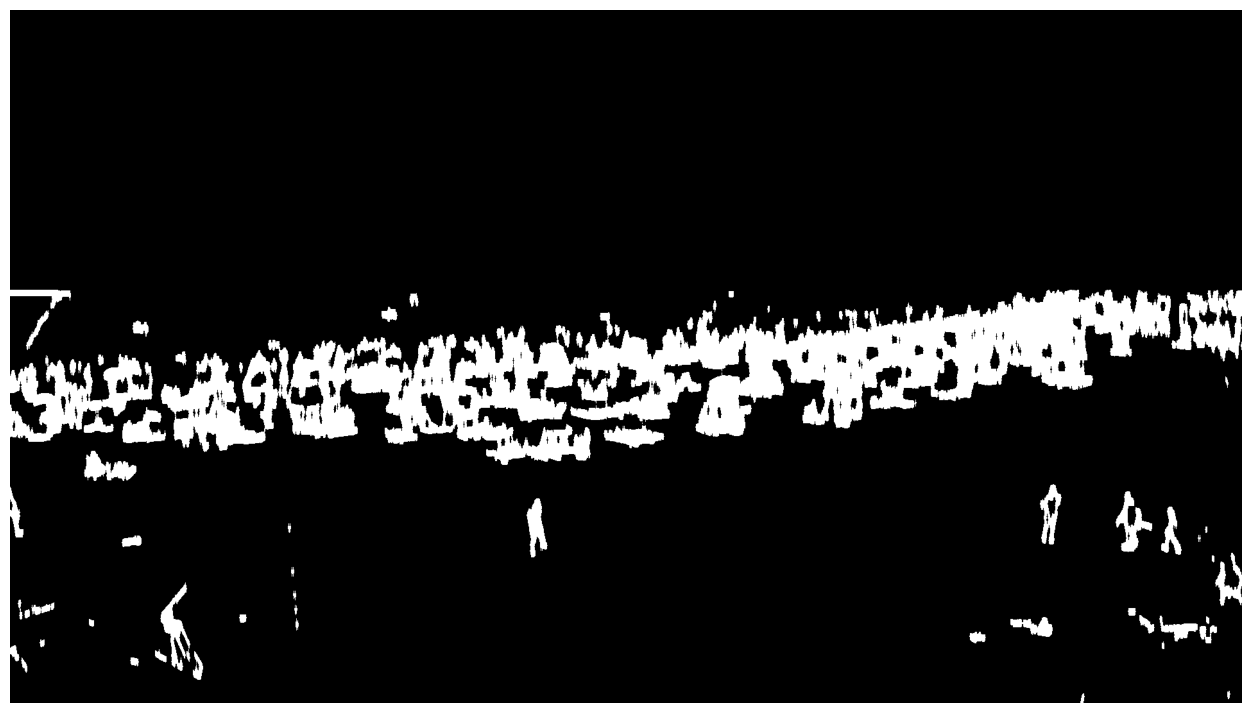

In [26]:
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))
plt.imshow(closed, cmap="gray")
plt.axis('off')

In [27]:
image_used = np.copy(image_stack_color[4])

image_used[0][closed == 0] = 0
image_used[1][closed == 0] = 0
image_used[2][closed == 0] = 0

image_used = np.transpose(image_used, (1, 2, 0))

(-0.5, 1919.5, 1079.5, -0.5)

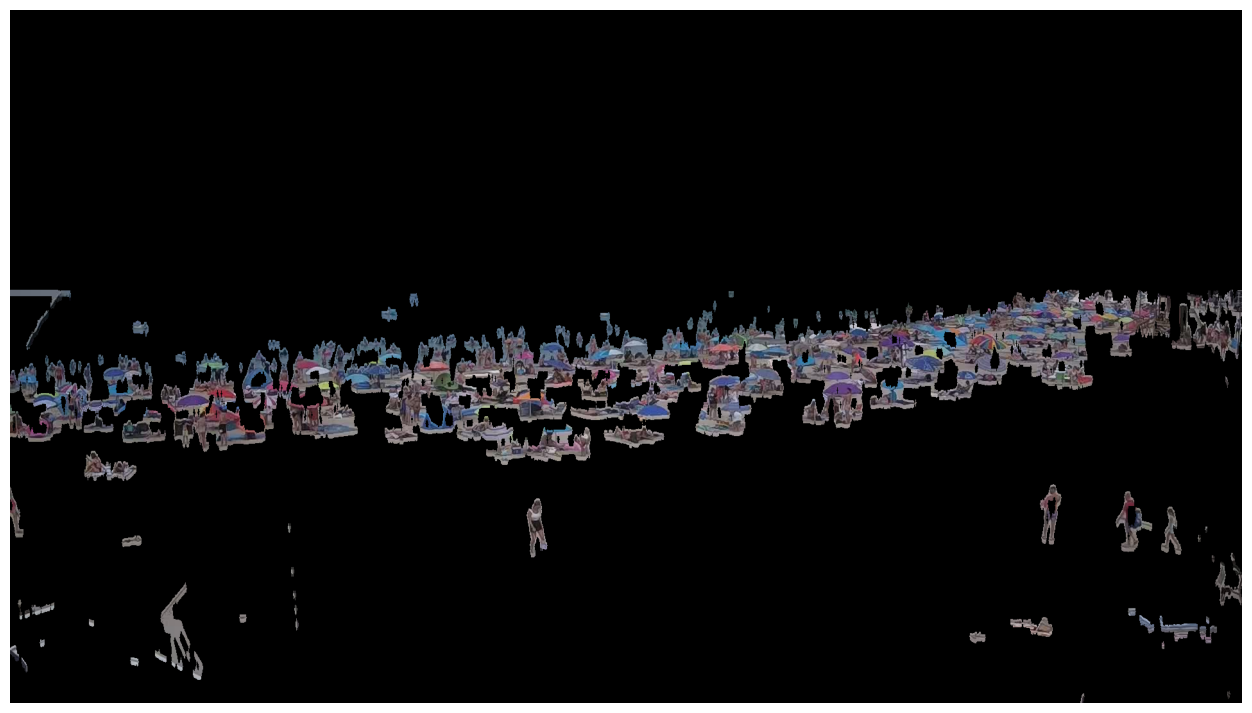

In [28]:
plt.imshow(image_used)
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

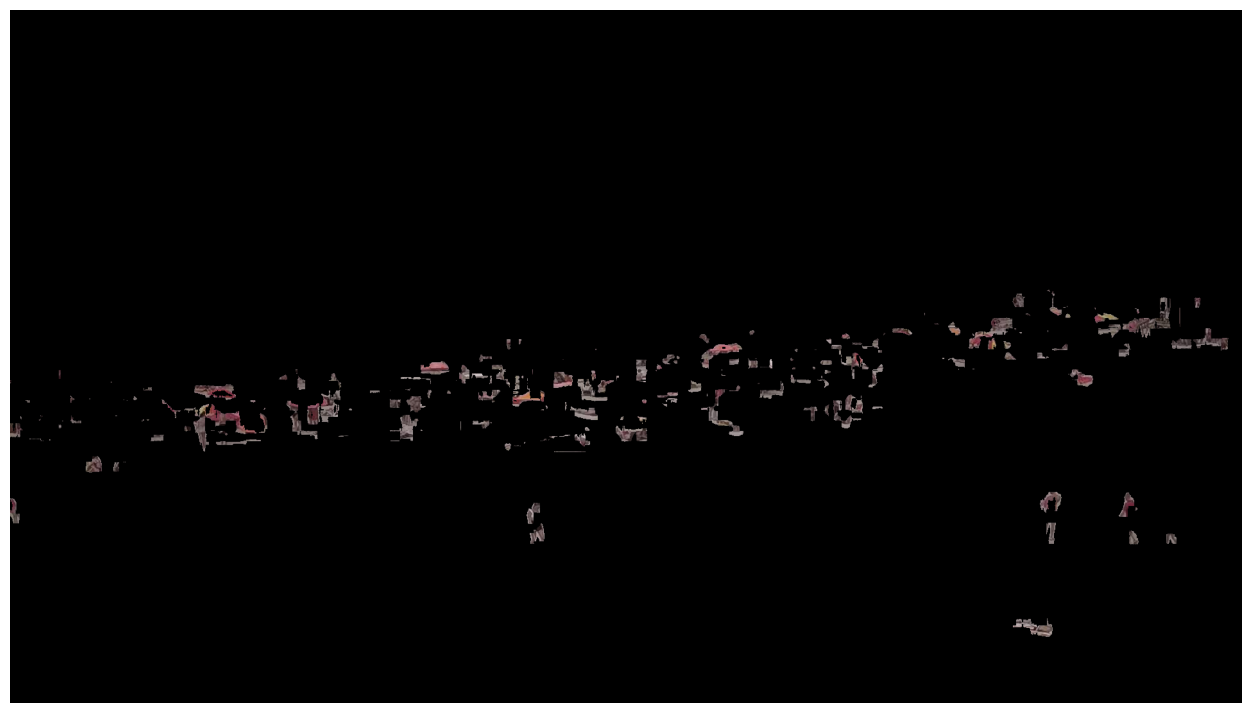

In [29]:
min_YCrCb = np.array([0, 133, 77], np.uint8)
max_YCrCb = np.array([235, 173, 127], np.uint8)

#img2 = cv2.imread("images/{}".format(images[5]), cv2.IMREAD_COLOR)
imageYCrCb = cv2.cvtColor(image_used, cv2.COLOR_RGB2YCR_CB)
skinRegionYCrCb = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

skinYCrCb = cv2.bitwise_and(image_used, image_used, mask=skinRegionYCrCb)
plt.imshow(skinYCrCb)
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

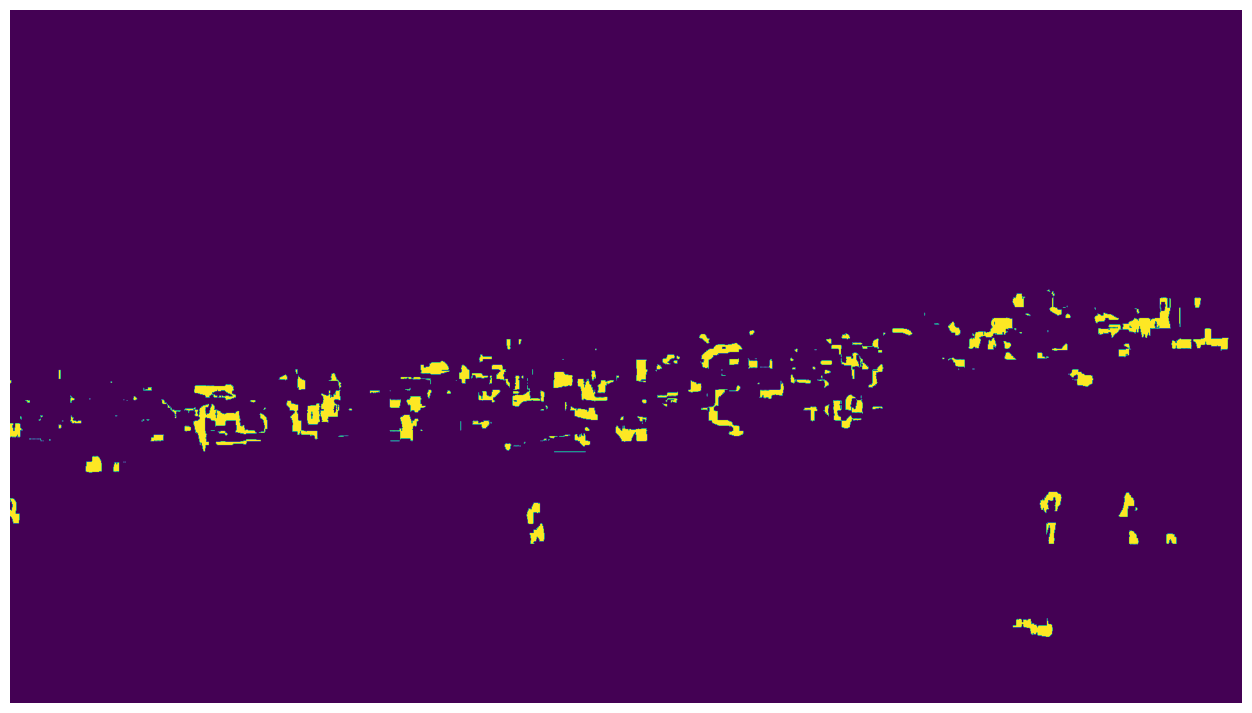

In [30]:
plt.imshow(skinRegionYCrCb)
plt.axis("off")

(-0.5, 1919.5, 1079.5, -0.5)

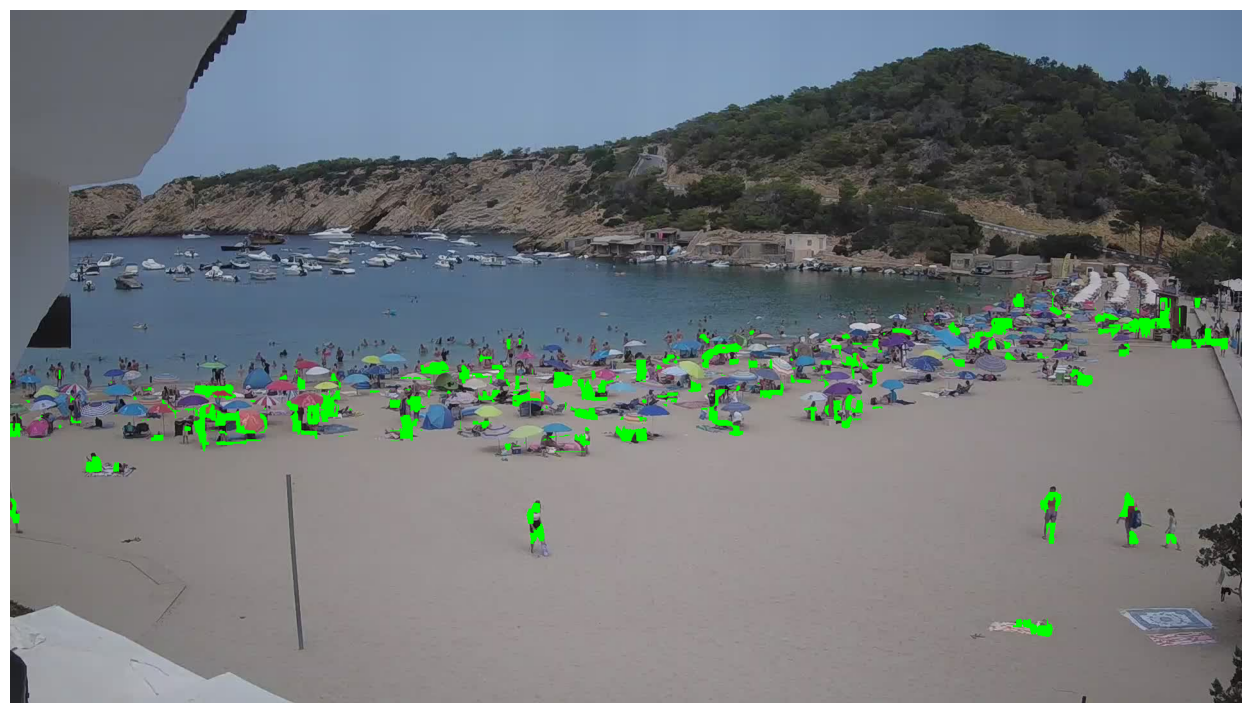

In [31]:
result = np.copy(image_stack_color[4])
result[0][skinRegionYCrCb == 255] = 0
result[1][skinRegionYCrCb == 255] = 255
result[2][skinRegionYCrCb == 255] = 0
result = np.transpose(result, (1, 2, 0))

plt.imshow(result)
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

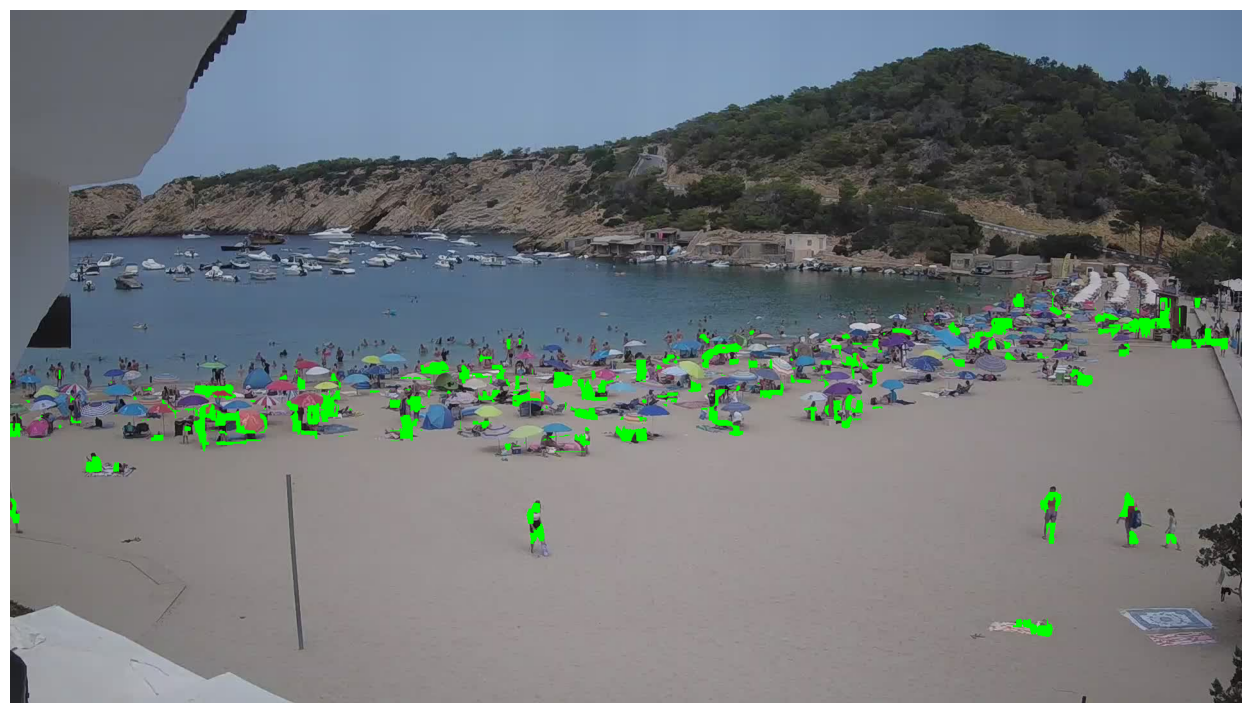

In [6]:
def detection_mask(image, diff):
    kernelSize = (10,18)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    tophat = cv2.morphologyEx(diff, cv2.MORPH_TOPHAT, kernel)
    
    edges = cv2.Canny(image=tophat, threshold1=100, threshold2=200)

    dilated = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    image_used = np.copy(image)

    image_used[0][closed == 0] = 0
    image_used[1][closed == 0] = 0
    image_used[2][closed == 0] = 0

    image_used = np.transpose(image_used, (1, 2, 0))
    
    mask = skin_color_filter(image_used)
    
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (7,7)))
    
    #mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    
    result = np.copy(image)
    result[0][mask == 255] = 0
    result[1][mask == 255] = 255
    result[2][mask == 255] = 0
    result = np.transpose(result, (1, 2, 0))
    
    return result, mask
    
    
def skin_color_filter(image):
    min_YCrCb = np.array([0, 133, 77], np.uint8)
    max_YCrCb = np.array([235, 173, 127], np.uint8)

    #img2 = cv2.imread("images/{}".format(images[5]), cv2.IMREAD_COLOR)
    imageYCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

    #skinYCrCb = cv2.bitwise_and(image, image, mask=skinRegionYCrCb)
    
    return skinRegionYCrCb

res, msk = detection_mask(image_stack_color[4], subs_image)

plt.imshow(res)
plt.axis("off")

In [7]:
def min_max_norm(image):
    min_val = np.min(image)
    max_val = np.max(image)

    norm_image = (image - min_val) / (max_val - min_val)
    return norm_image


def divide_img_sectors(image):
    # Find boundaries
    
    img_size = image.shape
    sqrt_arr = np.sqrt(np.linspace(1,img_size[0],8, dtype = np.int_))
    norm_arr = min_max_norm(sqrt_arr)
    cut_boundaries = img_size[0] - (norm_arr * img_size[0]).astype(int)

    
    tmp = np.repeat(cut_boundaries, 2)[1:-1]
    cut_boundaries_paris = tmp[:(len(tmp) // 2 + 1) * 2].reshape(-1, 2)
    image_list_sectors = []

    for pair_i in cut_boundaries_paris:
        img = image[pair_i[1]:pair_i[0],:].copy()
        image_list_sectors.append(img)

    return image_list_sectors

In [8]:
def find_people_sec(image_list):
    p_sector_list = [None] * len(image_list)

    # FIRST SECTOR
    _, bin_0 = cv2.threshold(image_list[0], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_0 = cv2.dilate(bin_0,kernel_dil,iterations = 1)

    kernelSize_open = (6,8)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[0] = bin_0

    
    # SECOND SECTOR
    _, bin_1 = cv2.threshold(image_list[1], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_1 = cv2.dilate(bin_1,kernel_dil,iterations = 1)

    kernelSize_open = (5,7)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[1] = bin_1

    
    # THIRD SECTOR
    _, bin_2 = cv2.threshold(image_list[2], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_2 = cv2.dilate(bin_2,kernel_dil,iterations = 1)

    kernelSize_open = (2,2)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (15,15)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[2] = bin_2

    
    # FORTH SECTOR
    _, bin_3 = cv2.threshold(image_list[3], 30, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (2,2)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_3 = cv2.erode(bin_3,kernel_dil,iterations = 1)

    
    kernelSize_close = (8,12)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (5,5)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[3] = bin_3

    
    # FIFTH SECTOR
    _, bin_4 = cv2.threshold(image_list[4], 20, 255, cv2.THRESH_BINARY)

    kernelSize_open = (6,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_OPEN, kernel_open)


    kernelSize_close = (7,8)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_CLOSE, kernel_close)

    p_sector_list[4] = bin_4

    
    # SIXTH SECTOR
    _, bin_5 = cv2.threshold(image_list[5], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (5,5)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (3,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[5] = bin_5

    
    # SEVENTH SECTOR
    _, bin_6 = cv2.threshold(image_list[6], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (7,7)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_6 = cv2.morphologyEx(bin_6, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_dil = (4,4)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_6 = cv2.dilate(bin_6,kernel_dil,iterations = 1)

    p_sector_list[6] = bin_6

    return p_sector_list

In [9]:
def find_people(tophat_img):
    #Cut mountain, boats and sky
    image_cut = tophat_img[440:,:].copy()

    #Divide image in sectors
    img_sectors = divide_img_sectors(image_cut)

    # Find people, create the mask
    mask = np.zeros(image_cut.shape, dtype = np.uint8)

    p_sector_list = find_people_sec(img_sectors)

    # Unify image sectors
    mask_h = mask.shape[0]
    pos_h = 0
    
    for img in p_sector_list:
    
        top_h = mask_h - (pos_h + img.shape[0])
        bot_h = mask_h - (pos_h)
        mask[top_h:bot_h,:] = img
        pos_h += img.shape[0]

    return mask

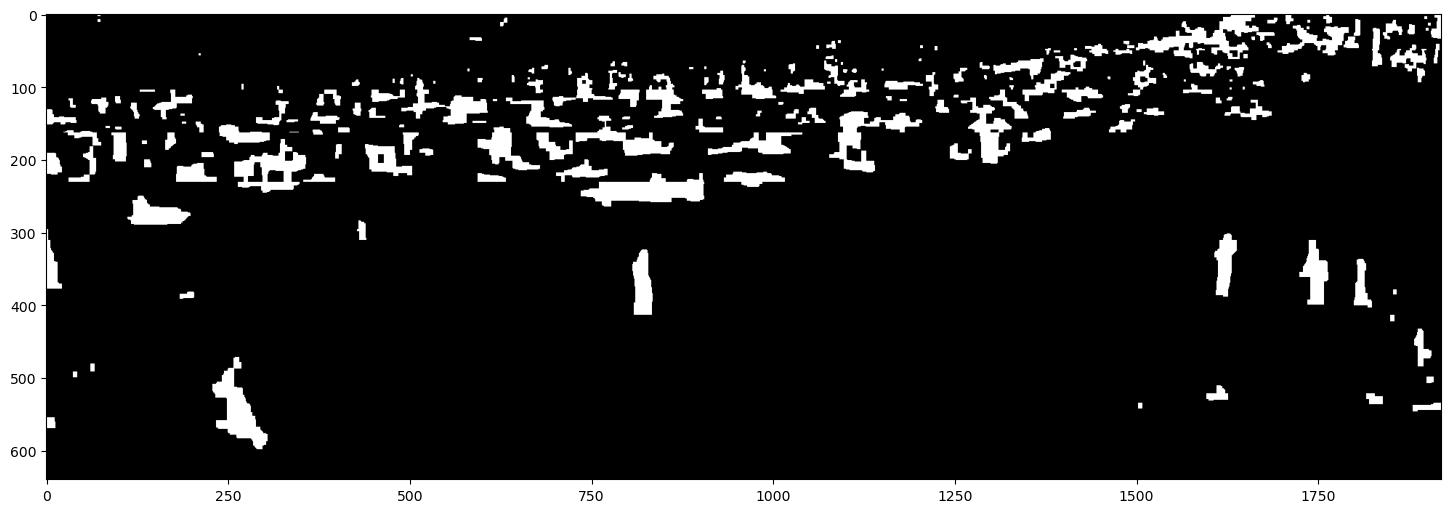

In [10]:
mask = find_people(tophat)
plt.imshow(mask, cmap = "gray")

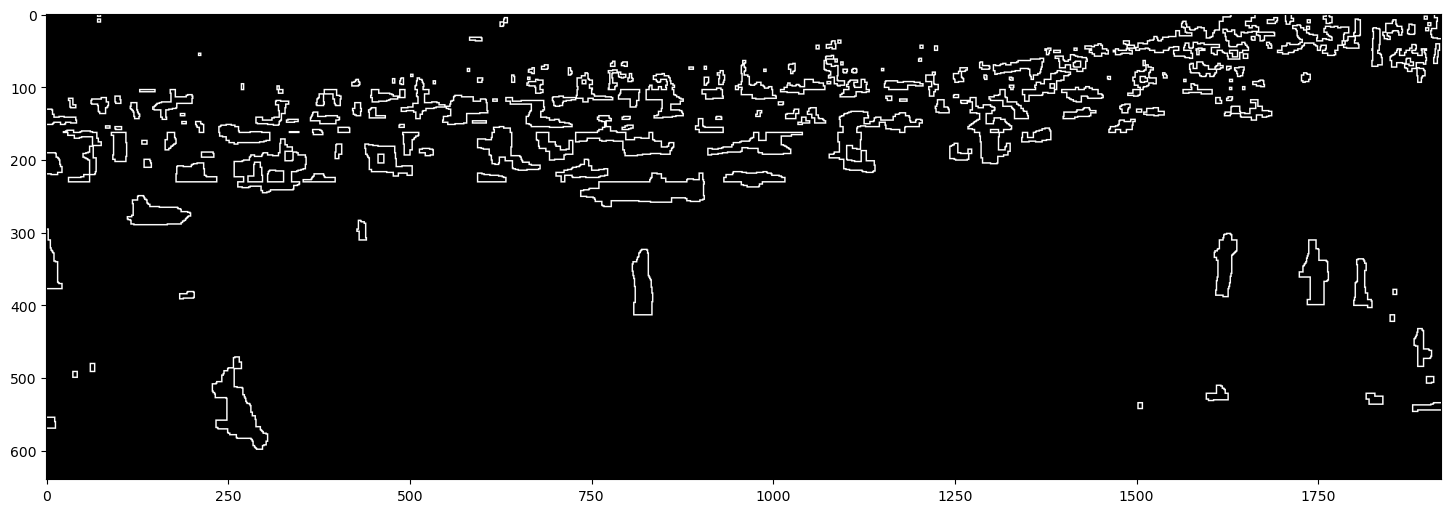

In [11]:
def get_gradient_img(img):
    # Gradient of mask
    kernelSize_close = (3,3)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel_close)

plt.imshow(get_gradient_img(mask), cmap = "gray")

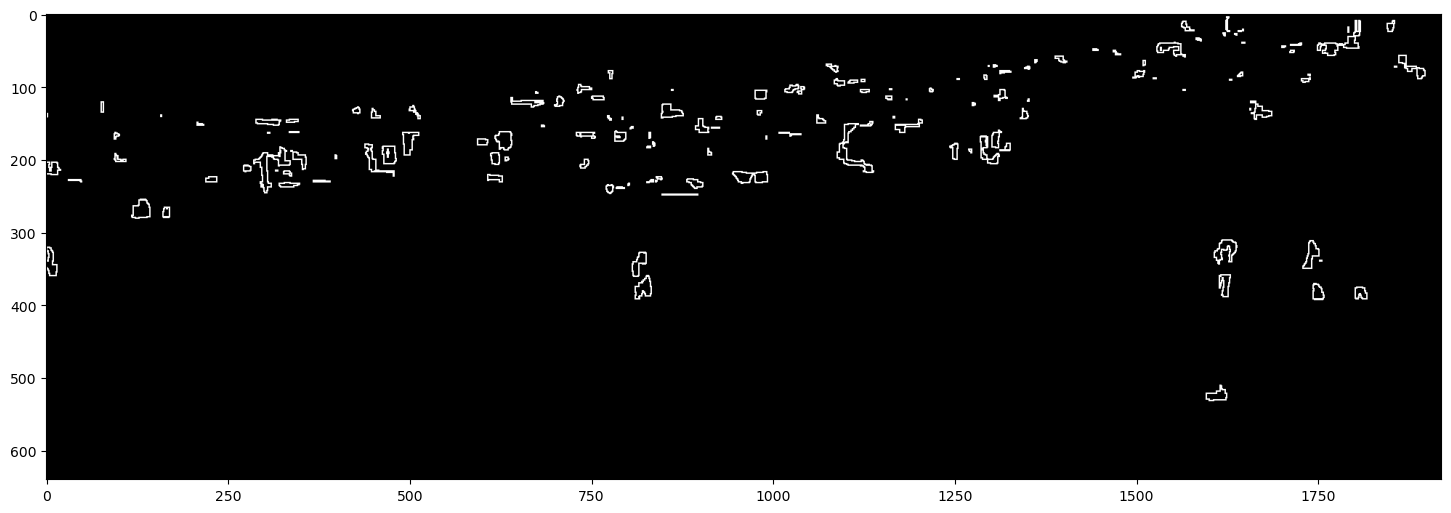

In [12]:
msk_cut = msk[440:,:].copy()
combined_mask = cv2.bitwise_and(mask, msk_cut)
plt.imshow(get_gradient_img(combined_mask), cmap="gray")

(-0.5, 1919.5, 1079.5, -0.5)

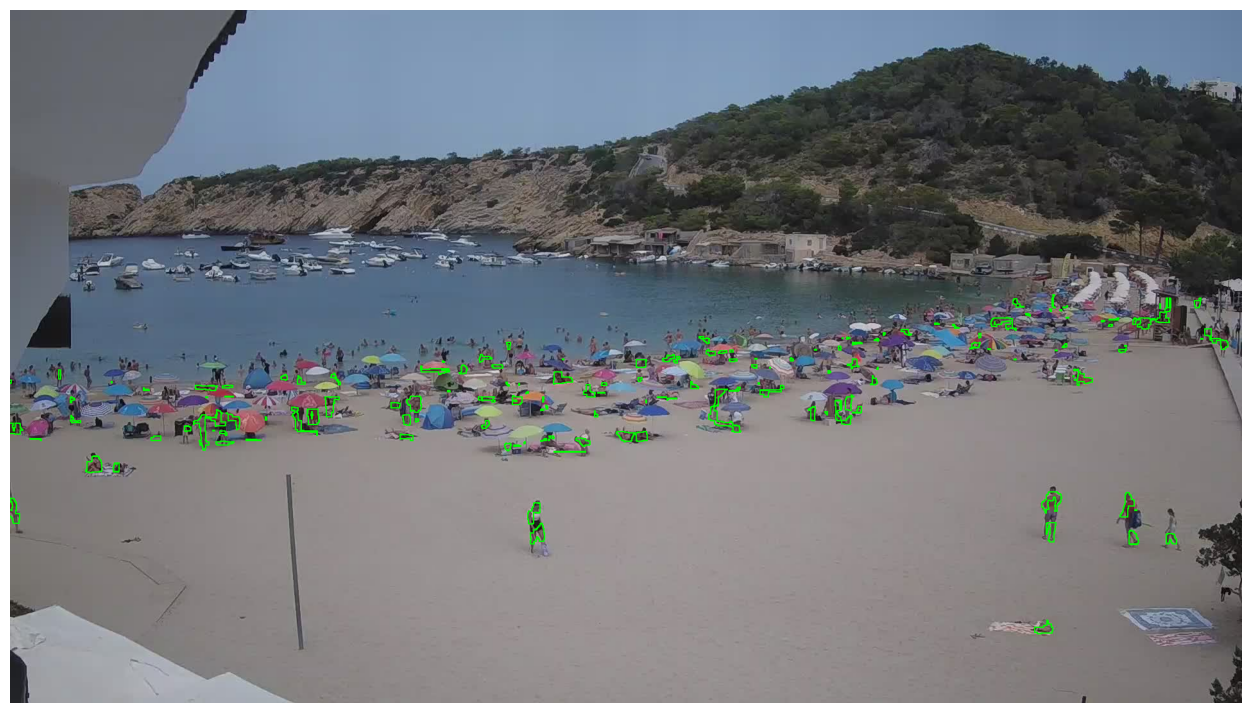

In [13]:
image_detected = image_stack_color[4].copy()
overline = get_gradient_img(combined_mask)

image_detected[0][440:,:][overline == 255] = 0
image_detected[1][440:,:][overline == 255] = 255
image_detected[2][440:,:][overline == 255] = 0
image_detected = np.transpose(image_detected, (1, 2, 0))

plt.imshow(image_detected)
plt.axis('off')

# FULL ALGORITHM

In [39]:
def load_data(directory: str):
    image_filenames = os.listdir(directory)
    image_filenames.sort()
    
    image_filenames.pop()
    for i in range(len(image_filenames)):
        image_filenames[i] = "{}/{}".format(directory,image_filenames[i])
    
    image_stack = np.stack([cv2.imread(filename, cv2.IMREAD_GRAYSCALE) for filename in image_filenames], axis=2)
    image_stack = np.transpose(image_stack, (2, 0, 1))
    
    image_stack_color = np.stack([cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for filename in image_filenames], axis=2)
    image_stack_color = np.transpose(image_stack_color, (2, 3, 0, 1))
    
    return image_stack, image_stack_color

# original_img = image_stack[idx]
def compute_tophat(original_img, empty_img):
    clahe = cv2.createCLAHE(clipLimit=1)

    empty_img_ = empty_img.copy()
    empty_img_[0:440,:] = 0
    
    image_mod_ = original_img.copy()
    image_mod_[0:440,:] = 0
    
    empty_image_ = clahe.apply(empty_img_)
    test_image_ = clahe.apply(image_mod_)
    
    diff = cv2.subtract(empty_image_, test_image_)
    
    kernelSize = (10,18)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    tophat = cv2.morphologyEx(diff, cv2.MORPH_TOPHAT, kernel)

    return tophat, diff


def detection_mask(image, tophat):
    edges = cv2.Canny(image=tophat, threshold1=100, threshold2=200)

    dilated = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    image_used = np.copy(image)

    image_used[0][closed == 0] = 0
    image_used[1][closed == 0] = 0
    image_used[2][closed == 0] = 0

    image_used = np.transpose(image_used, (1, 2, 0))
    
    mask = skin_color_filter(image_used)
    
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (7,7)))
    
    #mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    
    result = np.copy(image)
    result[0][mask == 255] = 0
    result[1][mask == 255] = 255
    result[2][mask == 255] = 0
    result = np.transpose(result, (1, 2, 0))
    
    return result, mask[440:,:]
    
    
def skin_color_filter(image):
    min_YCrCb = np.array([0, 133, 77], np.uint8)
    max_YCrCb = np.array([235, 173, 127], np.uint8)

    #img2 = cv2.imread("images/{}".format(images[5]), cv2.IMREAD_COLOR)
    imageYCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

    #skinYCrCb = cv2.bitwise_and(image, image, mask=skinRegionYCrCb)
    
    return skinRegionYCrCb

# ------------------------------------------------------------
# ------------------------------------------------------------

def min_max_norm(image):
    min_val = np.min(image)
    max_val = np.max(image)

    norm_image = (image - min_val) / (max_val - min_val)
    return norm_image


def divide_img_sectors(image):
    # Find boundaries
    
    img_size = image.shape
    sqrt_arr = np.sqrt(np.linspace(1,img_size[0],8, dtype = np.int_))
    norm_arr = min_max_norm(sqrt_arr)
    cut_boundaries = img_size[0] - (norm_arr * img_size[0]).astype(int)

    
    tmp = np.repeat(cut_boundaries, 2)[1:-1]
    cut_boundaries_paris = tmp[:(len(tmp) // 2 + 1) * 2].reshape(-1, 2)
    image_list_sectors = []

    for pair_i in cut_boundaries_paris:
        img = image[pair_i[1]:pair_i[0],:].copy()
        image_list_sectors.append(img)

    return image_list_sectors

def find_people_sec(image_list):
    p_sector_list = [None] * len(image_list)

    # FIRST SECTOR
    _, bin_0 = cv2.threshold(image_list[0], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_0 = cv2.dilate(bin_0,kernel_dil,iterations = 1)

    kernelSize_open = (6,8)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[0] = bin_0

    
    # SECOND SECTOR
    _, bin_1 = cv2.threshold(image_list[1], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_1 = cv2.dilate(bin_1,kernel_dil,iterations = 1)

    kernelSize_open = (5,7)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[1] = bin_1

    
    # THIRD SECTOR
    _, bin_2 = cv2.threshold(image_list[2], 55, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_2 = cv2.dilate(bin_2,kernel_dil,iterations = 1)

    kernelSize_open = (2,2)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (15,15)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[2] = bin_2

    
    # FORTH SECTOR
    _, bin_3 = cv2.threshold(image_list[3], 30, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (2,2)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_3 = cv2.erode(bin_3,kernel_dil,iterations = 1)

    
    kernelSize_close = (8,12)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (5,5)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[3] = bin_3

    
    # FIFTH SECTOR
    _, bin_4 = cv2.threshold(image_list[4], 20, 255, cv2.THRESH_BINARY)

    kernelSize_open = (6,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_OPEN, kernel_open)


    kernelSize_close = (7,8)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_CLOSE, kernel_close)

    p_sector_list[4] = bin_4

    
    # SIXTH SECTOR
    _, bin_5 = cv2.threshold(image_list[5], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (5,5)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (3,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[5] = bin_5

    
    # SEVENTH SECTOR
    _, bin_6 = cv2.threshold(image_list[6], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (7,7)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_6 = cv2.morphologyEx(bin_6, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_dil = (4,4)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_6 = cv2.dilate(bin_6,kernel_dil,iterations = 1)

    p_sector_list[6] = bin_6

    return p_sector_list

def find_people(tophat_img):
    #Cut mountain, boats and sky
    image_cut = tophat_img[440:,:].copy()

    #Divide image in sectors
    img_sectors = divide_img_sectors(image_cut)

    # Find people, create the mask
    mask = np.zeros(image_cut.shape, dtype = np.uint8)

    p_sector_list = find_people_sec(img_sectors)

    # Unify image sectors
    mask_h = mask.shape[0]
    pos_h = 0
    
    for img in p_sector_list:
    
        top_h = mask_h - (pos_h + img.shape[0])
        bot_h = mask_h - (pos_h)
        mask[top_h:bot_h,:] = img
        pos_h += img.shape[0]

    return mask


def get_outline_img(img):
    # Gradient of mask
    kernelSize_close = (3,3)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel_close)


#mask, msk
#msk_cut = msk[440:,:].copy()
def and_combine_masks(msk1, msk2):
    return cv2.bitwise_and(msk1, msk2)

# color in (R,G,B)
def apply_mask_outline_to_img(img, mask_, color):
    image_detected = img.copy()
    overline = get_outline_img(mask_)
    
    image_detected[0][440:,:][overline == 255] = color[0]
    image_detected[1][440:,:][overline == 255] = color[1]
    image_detected[2][440:,:][overline == 255] = color[2]
    image_detected = np.transpose(image_detected, (1, 2, 0))
    
    return image_detected

## EXECUTION

### Version 1

In [40]:
gray_images, color_images = load_data("data")

empty_beach = gray_images[1]

results_method_1 = []
results_method_2 = []
results_combined = []

for i in range(len(gray_images)):
    image_gray = gray_images[i]
    image_color = color_images[i]
    
    tophat, diff = compute_tophat(image_gray, empty_beach)
    
    _,detection_msk = detection_mask(image_color, tophat)
    results_method_1.append(apply_mask_outline_to_img(image_color, detection_msk, np.array([255, 0, 0])))
    
    people_mask = find_people(tophat)
    results_method_2.append(apply_mask_outline_to_img(image_color, people_mask, np.array([255, 0, 0])))
    
    resulting_mask = and_combine_masks(people_mask, detection_msk)
    result_image = apply_mask_outline_to_img(image_color, resulting_mask, np.array([255, 0, 0]))
    results_combined.append(result_image)


(-0.5, 1919.5, 1079.5, -0.5)

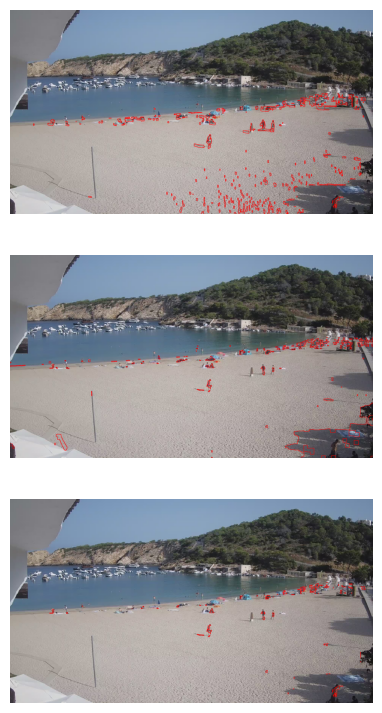

In [43]:
index = 3

fig = plt.figure()
fig.add_subplot(3,1,1)
plt.imshow(results_method_1[index])
plt.axis("off")

fig.add_subplot(3,1,2)
plt.imshow(results_method_2[index])
plt.axis("off")

fig.add_subplot(3,1,3)
plt.imshow(results_combined[index])
plt.axis("off")

### Version 2

In [45]:
contours = cv2.findContours(people_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
filtering_contours = cv2.findContours(resulting_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

keep_contours = []
used_filters = np.zeros(len(filtering_contours[0]))

for contour in contours[0]:
    keep_contour = False
    
    for idx, filter in enumerate(filtering_contours[0]):
        #if used_filters[idx]:
        #    continue
        
        for pixel in filter:
            representing_pixel = (int(pixel[0][0]), int(pixel[0][1]))
        
            if cv2.pointPolygonTest(contour=contour, pt=representing_pixel, measureDist=False) != -1:
                keep_contour = True
                used_filters[idx] = 1
                break
        
        if keep_contour:
            break
    
    keep_contours.append(keep_contour)
    
print(used_filters)

[1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0.]


In [46]:
contours = cv2.findContours(people_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
filtering_contours = cv2.findContours(resulting_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

keep_contours_ = []
used_filters_ = np.zeros(len(filtering_contours[0]))

for contour in contours[0]:
    keep_contour = False
    
    for idx, filter in enumerate(filtering_contours[0]):
        #if used_filters[idx]:
        #    continue
        
        representing_pixel = (int(filter[0][0][0]), int(filter[0][0][1]))
        
        if cv2.pointPolygonTest(contour=contour, pt=representing_pixel, measureDist=False) != -1:
            keep_contour = True
            used_filters_[idx] = 1
            break        
    
    keep_contours_.append(keep_contour)
    
print(used_filters_)

[1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0.]


In [62]:
used_filters == used_filters_

# CASOS EXTREMOS -> MUCHO MAS TIEMPO DE COMPUTACION -> VALE LA PENA?

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [47]:
def filter_regions(image,mask):
    contours = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    filtering_contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    keep_contours_ = []
    used_filters_ = np.zeros(len(filtering_contours[0]))
    
    for contour in contours[0]:
        keep_contour = False
        
        for idx, filter in enumerate(filtering_contours[0]):
            #if used_filters[idx]:
            #    continue
            
            representing_pixel = (int(filter[0][0][0]), int(filter[0][0][1]))
            
            if cv2.pointPolygonTest(contour=contour, pt=representing_pixel, measureDist=False) != -1:
                keep_contour = True
                used_filters_[idx] = 1
                break        
        
        keep_contours_.append(keep_contour)
        
    result = np.zeros_like(image)
    filtered_contours = list(compress(list(contours[0]), keep_contours_))
    cv2.drawContours(result, filtered_contours, -1, 255)
    
    return result

In [49]:
results_combined_2 = []

for i in range(len(gray_images)):
    image_gray = gray_images[i]
    image_color = color_images[i]
    
    tophat, diff = compute_tophat(image_gray, empty_beach)
    
    _,detection_msk = detection_mask(image_color, tophat)    
    people_mask = find_people(tophat)

    intermediate_mask = and_combine_masks(people_mask, detection_msk)
    
    resulting_mask = filter_regions(people_mask, intermediate_mask)

    result_image = apply_mask_outline_to_img(image_color, resulting_mask, np.array([255, 0, 0]))
    results_combined_2.append(result_image)

(-0.5, 1919.5, 1079.5, -0.5)

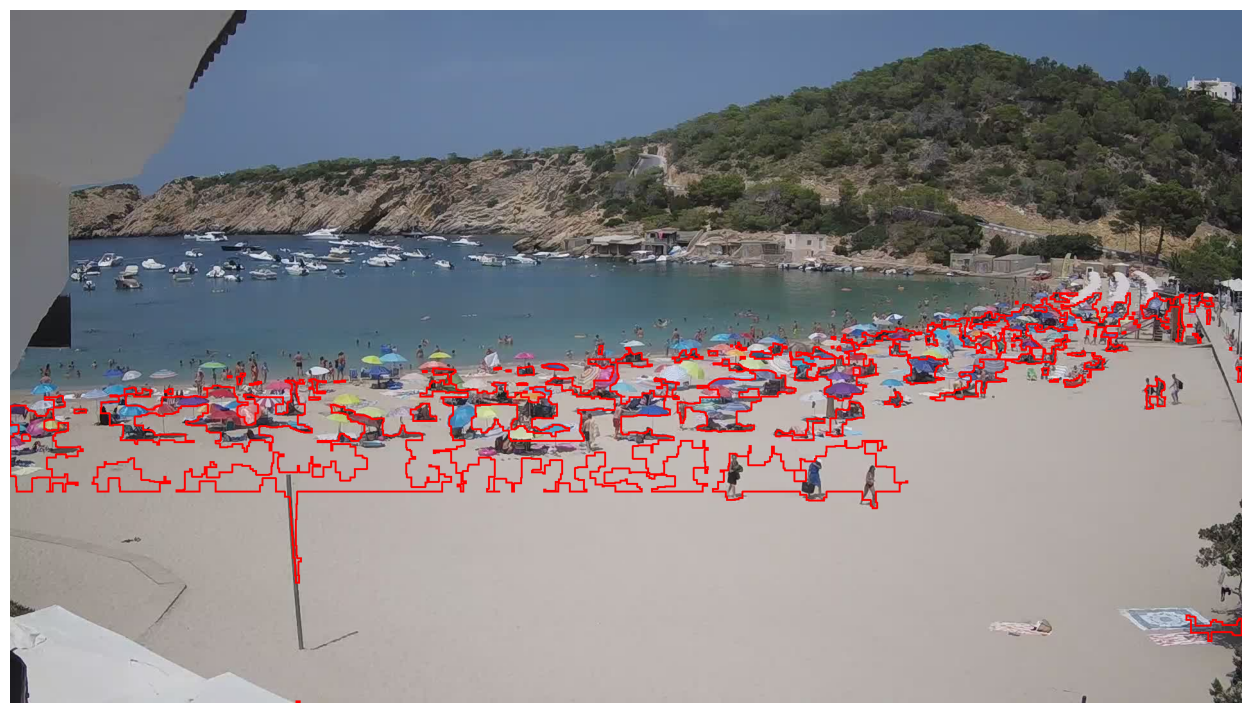

In [51]:
index = 8
plt.imshow(results_combined_2[index])
plt.axis("off")